# Table of Contents 

- [Parameters and hyperparameters](#Parameters-and-Hyperparameters)
- [Hyperparameters tuning](#Hyperparameters-tuning)
- [Putting it all together: hyperparameters tuning and pipelines](#Putting-it-all-together:-hyperparameters-tuning-and-pipelines)
- [Nested cross-validation](#Nested-cross-validation)


Bibliography: 
- Bergstra, J. and Bengio, Y., *"[Random search for hyper-parameter optimization](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)"*, The Journal of Machine Learning Research (2012): 281-305 
- Cawley, Gavin C., and Nicola LC Talbot. *"[On over-fitting in model selection and subsequent selection bias in performance evaluation.](https://www.jmlr.org/papers/volume11/cawley10a/cawley10a.pdf)"* The Journal of Machine Learning Research 11 (2010): 2079-2107.


# Parameters and Hyperparameters

- Most ML algorithms are based on some form of multi-level inference, where the model is defined by
    - a set of model **parameters**
    - a set of **hyper-parameters**
- For example in *decision tree* learning methods 
    - the parameters include the attributes and splitting points considered in each internal node 
    - the hyper-parametes include, for instance, the splitting criterion, the maximum depth and the list goes on ..
     


In scikit-learn hyper-paramters are passed as arguments to the constructor of the estimator classes.
```python
class sklearn.tree.DecisionTreeClassifier(*, 
                                          criterion='gini', 
                                          splitter='best', 
                                          max_depth=None, 
                                          min_samples_split=2, 
                                          min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, 
                                          max_features=None, 
                                          random_state=None, 
                                          max_leaf_nodes=None, 
                                          min_impurity_decrease=0.0, 
                                          class_weight=None, 
                                          ccp_alpha=0.0, 
                                          monotonic_cst=None)
```

- This division into parameters and hyper-parameters is typically performed for **computational convenience**.
- It makes sense to take advantage of this structure and fit the model iteratively using a pair of nested loops:
    - the **hyper-parameters** adjusted to optimise a model selection criterion in the inner loop (model selection)
    - the **parameters** set to optimise a training criterion in the outer loop (model fitting/training)

# Hyperparameters tuning

From the [sklearn documentation](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator):


- It is possible and recommended to search the hyper-parameter space for the best cross validation score.\
A **search** consists of:
    - an estimator;
    - a parameter space;
    - a method for searching or sampling candidates;
    - a cross-validation scheme; 
    - a score function.



When we have just to tune a **small number of hyperparameters**, two viable approaches are **grid search** and **random search**. 
- For given values, **grid search** exhaustively considers all parameter combinations.
- **Random search** can sample a given number of candidates from a parameter space with a specified distribution.


Which one is better (i.e. more effective/efficient)? 





**Aside**

The increasing attention gained by ML/DL has fostered the development of other, more sophisticated, algorithmic approaches for hyperparameter tuning, including [Bayesian optimization](https://distill.pub/2020/bayesian-optimization/) approaches and gradient based approaches.

In [22]:
from time import time
import seaborn as sns     
from matplotlib import pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [23]:
# get some data
X, y = load_digits(return_X_y=True, n_class=3)
len(X),len(y)

(537, 537)

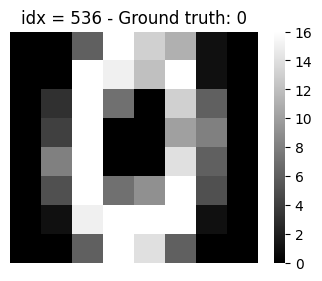

In [24]:
check_idx = 536
plt.figure(figsize=(4,3))
sns.heatmap(X[check_idx].reshape(8,8), cmap = 'gray', yticklabels=False, xticklabels=False)
plt.title(f'idx = {check_idx} - Ground truth: {y[check_idx]}')
plt.show()

In [25]:
# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: f{results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [26]:
skf = StratifiedKFold(n_splits=10)

In [27]:
clf = DecisionTreeClassifier(random_state = 42)

A search consists of:
- an estimator --> 👆✅ clf as instance of DecisionTreeClassifier 
- a cross-validation scheme --> 👆✅ skf as instance of StratifiedKFold cross-validation
- a score function --> ✅ default for DT: accuracy score
- a parameter space; --> 👇✅ defined below, two dimensions
- a method for searching or sampling candidates --> 👇✅ we'll use both grid and random search

The stage is set!

In [28]:
# specify parameters and distributions to sample from
param_dist = {
    "max_depth": range(2,15),
    "min_samples_split": range(2,10,2),
}

# run randomized search
n_iter_search = 9
random_search = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search, 
                                   random_state = 42,
                                   cv=skf)

# fit and report
start = time()
random_search.fit(X, y)
print(f"RandomizedSearchCV took {(time() - start):.2f} seconds for {n_iter_search} candidates parameter settings.\n")
report(random_search.cv_results_)

RandomizedSearchCV took 0.26 seconds for 9 candidates parameter settings.

Model with rank: 1
Mean validation score: f0.940 (std: 0.050)
Parameters: {'min_samples_split': 4, 'max_depth': 12}

Model with rank: 1
Mean validation score: f0.940 (std: 0.053)
Parameters: {'min_samples_split': 8, 'max_depth': 13}

Model with rank: 1
Mean validation score: f0.940 (std: 0.053)
Parameters: {'min_samples_split': 8, 'max_depth': 12}

Model with rank: 1
Mean validation score: f0.940 (std: 0.053)
Parameters: {'min_samples_split': 6, 'max_depth': 14}

Model with rank: 5
Mean validation score: f0.933 (std: 0.060)
Parameters: {'min_samples_split': 2, 'max_depth': 5}

Model with rank: 5
Mean validation score: f0.933 (std: 0.060)
Parameters: {'min_samples_split': 4, 'max_depth': 6}

Model with rank: 7
Mean validation score: f0.929 (std: 0.059)
Parameters: {'min_samples_split': 8, 'max_depth': 6}

Model with rank: 8
Mean validation score: f0.926 (std: 0.042)
Parameters: {'min_samples_split': 4, 'max_depth

In [29]:
random_params = list(zip(random_search.cv_results_['param_max_depth'].data,
                         random_search.cv_results_['param_min_samples_split'].data))

In [30]:
# use a full grid over all parameters
param_grid = {
    "max_depth": range(2,15),
    "min_samples_split": range(2,10,2),
}

# run grid search
grid_search = GridSearchCV(clf, 
                           param_grid=param_grid,
                           cv=skf)

# fit and report
start = time()
grid_search.fit(X, y)
print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_)

GridSearchCV took 1.45 seconds for 52 candidates parameter settings.

Model with rank: 1
Mean validation score: f0.940 (std: 0.050)
Parameters: {'max_depth': 10, 'min_samples_split': 4}

Model with rank: 1
Mean validation score: f0.940 (std: 0.053)
Parameters: {'max_depth': 10, 'min_samples_split': 6}

Model with rank: 1
Mean validation score: f0.940 (std: 0.053)
Parameters: {'max_depth': 10, 'min_samples_split': 8}

Model with rank: 1
Mean validation score: f0.940 (std: 0.050)
Parameters: {'max_depth': 11, 'min_samples_split': 4}

Model with rank: 1
Mean validation score: f0.940 (std: 0.053)
Parameters: {'max_depth': 11, 'min_samples_split': 6}

Model with rank: 1
Mean validation score: f0.940 (std: 0.053)
Parameters: {'max_depth': 11, 'min_samples_split': 8}

Model with rank: 1
Mean validation score: f0.940 (std: 0.050)
Parameters: {'max_depth': 12, 'min_samples_split': 4}

Model with rank: 1
Mean validation score: f0.940 (std: 0.053)
Parameters: {'max_depth': 12, 'min_samples_split'

In [31]:
grid_search.cv_results_

{'mean_fit_time': array([0.00152202, 0.00156617, 0.00154433, 0.00142574, 0.00188181,
        0.00179746, 0.00194569, 0.00191612, 0.00215111, 0.00228269,
        0.00212593, 0.00210776, 0.00224216, 0.00204134, 0.00209646,
        0.0021723 , 0.00211494, 0.00214858, 0.00264287, 0.00208247,
        0.00228879, 0.00224991, 0.00223219, 0.00222549, 0.00243552,
        0.00224426, 0.00230293, 0.00230691, 0.00237107, 0.0023581 ,
        0.00237095, 0.0025733 , 0.00255687, 0.00253291, 0.00248241,
        0.00246162, 0.00249228, 0.00240099, 0.00234838, 0.00238721,
        0.00244532, 0.00232146, 0.00234263, 0.00224428, 0.00235152,
        0.00229077, 0.00234497, 0.00237138, 0.00237801, 0.00233204,
        0.00222821, 0.00225766]),
 'std_fit_time': array([1.05946832e-04, 9.35300011e-05, 8.43116463e-05, 5.54284997e-05,
        1.21419326e-04, 1.38933871e-04, 2.17707596e-04, 1.57232951e-04,
        2.09715676e-04, 3.59971111e-04, 1.60693868e-04, 2.56768778e-04,
        3.64377713e-04, 1.69204643e-0

In [32]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                     values='mean_test_score', 
                     index='param_max_depth', 
                     columns='param_min_samples_split')

pvt

param_min_samples_split,2,4,6,8
param_max_depth,,,,
2,0.906883,0.906883,0.906883,0.906883
3,0.925611,0.925611,0.925611,0.925611
4,0.923515,0.921628,0.921628,0.923515
5,0.932844,0.932844,0.929140,0.929140
6,0.930957,0.932844,0.929140,0.929140
7,0.930957,0.932844,0.932844,0.932844
8,0.930957,0.932844,0.932844,0.932844
9,0.936513,0.938400,0.938400,0.938400
10,0.938365,0.940252,0.940252,0.940252


In [33]:
list(random_params)

[(np.int64(6), np.int64(8)),
 (np.int64(12), np.int64(4)),
 (np.int64(13), np.int64(8)),
 (np.int64(5), np.int64(2)),
 (np.int64(12), np.int64(8)),
 (np.int64(3), np.int64(4)),
 (np.int64(6), np.int64(4)),
 (np.int64(14), np.int64(6)),
 (np.int64(2), np.int64(8))]

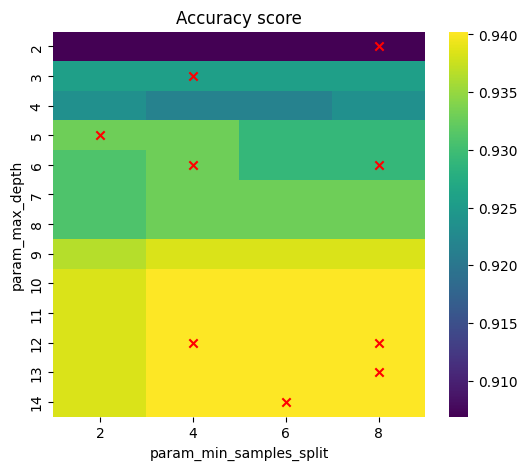

In [34]:
f,ax = plt.subplots(figsize = (6,5))
sns.heatmap(pvt, cmap='viridis',ax = ax)
plt.title('Accuracy score')
for i in random_params:
    ax.scatter(i[1]/2-0.5,i[0]-1.5,color = 'r',marker = 'x')
    # red crosses inidcate configurations tested by random search

So, **which one is better** (i.e. more effective/efficient)? 

An answer has been recently provided by Bergstra and Bengio in [this work](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) from 2012.
- It is quite common that the hyperparameter optimization functions have a *low effective dimensionality*, i.e. they are more sensitive to changes in some dimensions than others.
    - If we are aware of the most influential dimensions, we can desing an appropriate grid search.
    - Otherwise, it is better to resort to random search.

Consider the following example in which we have a granted budget of 9 trials to explore a bidimensional hyperparameter space.

<div>
<img src="https://miro.medium.com/proxy/1*ZTlQm_WRcrNqL-nLnx6GJA.png" width="700"/>
</div>

- The **grid search** provides an even coverage of the original 2D space, but projections on the two dimensions produces a poor and inefficient coverage of the 1D subspaces. 
- Conversely, **random search** provides a less evenly distributed coverage of the original space, but obtains a far more detailed insight on both the subspaces.

More formally: the function $f$ to optimize can be approximated as $g$ due to low effective dimensionality:

$$f(x, y) = g(x) + h(y) ≈ g(x)$$

- **Grid search** tests $g$, represented as green plot in the above figure, for only three different values of $x$. 
- **Random search**, instead, tests distinct values in all nine trials.


*Notice*: It is recommended to read the docstring of the estimator class to get a finer understanding of their expected behavior, possibly by reading the enclosed reference to the literature.

# Putting it all together: hyperparameters tuning and pipelines

- GridSearchCV and RandomizedSearchCV allow searching over parameters of composite or nested estimators such as Pipeline using a dedicated `<estimator>__<parameter>` syntax.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.datasets import load_digits

scaler = StandardScaler()
pca = PCA()

logistic = LogisticRegression(max_iter=10000)

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

X_digits, y_digits = load_digits(return_X_y=True)

In [36]:
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "logistic__C": np.logspace(-4, 4, 4), #Inverse of regularization strength; must be a positive float.

}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.923):
{'logistic__C': np.float64(0.046415888336127774), 'pca__n_components': 60}


In [37]:
dir(search)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_format_results',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_routed_params_for_fit',
 '_get_scorers',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_run_sea

In [38]:
search.cv_results_

{'mean_fit_time': array([0.016364  , 0.01490855, 0.01571617, 0.01586924, 0.01798935,
        0.02536149, 0.02603302, 0.02516484, 0.02639656, 0.02839127,
        0.05041957, 0.07397757, 0.04370198, 0.03093104, 0.03105574,
        0.04928803, 0.13951468, 0.03263321, 0.02117405, 0.01827025]),
 'std_fit_time': array([0.00161216, 0.00186302, 0.00241148, 0.00153462, 0.0018395 ,
        0.00218194, 0.00547709, 0.00330064, 0.00247639, 0.00306248,
        0.00865943, 0.01028374, 0.00546353, 0.00271402, 0.00212732,
        0.00940693, 0.03522136, 0.01016274, 0.00235502, 0.00295436]),
 'mean_score_time': array([0.00214376, 0.00202103, 0.00205235, 0.00213242, 0.00214729,
        0.0019495 , 0.00184197, 0.00194616, 0.00202885, 0.00197644,
        0.00179834, 0.00200801, 0.00202861, 0.00206428, 0.00196176,
        0.00191121, 0.0018508 , 0.00233474, 0.00215049, 0.00163918]),
 'std_score_time': array([1.59916752e-04, 1.39849144e-04, 1.53375871e-04, 1.88894874e-04,
        3.39385731e-04, 1.06281259e-

In [39]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(search.cv_results_),
                     values='mean_test_score', 
                     index='param_pca__n_components', 
                     columns='param_logistic__C')

pvt

param_logistic__C,0.000100,0.046416,21.544347,10000.000000
param_pca__n_components,,,,
5,0.683918,0.772963,0.768508,0.768508
15,0.782985,0.898171,0.880378,0.868694
30,0.807461,0.912083,0.896501,0.884256
45,0.811356,0.922662,0.907642,0.908194
60,0.810800,0.923219,0.913210,0.910421


# Nested cross-validation

Two core components of best practices in ML (real-world application as well as research): **performance evaluation** and **model selection**.



- Hyperparameter tuning is part of the **model selection** component.
- At the same time, unbiased and robust **performance evaluation** is one cornerstone of ML: without a reliable indication of the relative performance of competing algorithms, possibly across a wide range of learning tasks, we cannot have the clear picture of their **generalization capability**.


**How to perform these two steps in a fair, robust and unbiased manner?**

<font color=red>**A**. Say you use *GridSearchCV* or *RandomizedSearchCV* to optimize hyperparameters. Is the score measured for the best setting indicative of the generalization capability of the model (i.e., good proxy for performance evaluation)?</font> 👎

- When evaluating different hyperparameters for estimators there is still a risk of overfitting because the parameters can be tweaked until the estimator performs optimally.
    - This way, knowledge about the test sets (i.e., the "folds out") can leak into the model and evaluation metrics no longer report on generalization performance.
    - In other words, an optimistic bias is introduced into the performance estimate as it has been directly optimised in tuning the hyperparameters.



<font color=green>**B**. Solution in case a hold out test-set is available</font> 👍


      
- If a test set is held out from the whole data, we can perform the final evaluation on it.
    - Hyperparametr tuning (model selection) can be carried out using cross-validation over the training set.
        -  Notice: sometimes, instead of using cross-validation, a part of the training set is held out as a so-called *validation set*, which is used to evaluate different models/hyperparameters. However, the results can depend on a particular random choice for the pair of (train, validation) sets.
    - When the experiment seems to be successful (found optimal hyperparameters, based on the results in cross-validation), the final evaluation can be done on the test set.


<div>
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="800"/>
</div>

<font color=green>**C**. Solution in case a hold out test-set is NOT available: **Nested cross-validation**</font> 👍


- An **inner cross-validation** is used for model selection: the score is approximately maximized by fitting a model to each training set, and then directly maximized in selecting hyperparameters over the validation sets (gray boxes)
- An **outer cross-validation** is used for performance evaluation: generalization error is estimated by measuring test set scores over several dataset splits (light green boxes).


<div>
<img src="./images/vh1sZ.png" width="800"/>
</div>

*Why can't I just use a single cross-validation level (option A)*:
- Model selection without nested cross-validation uses the same data to tune model parameters and evaluate model performance.
- Information may thus "leak" into the model and overfit the data, yielding an overly-optimistic score. 

Check out the [sklearn example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py):

In [40]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.svm import SVC

# Number of random trials
NUM_TRIALS = 100

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

In [41]:
# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    # Note that inner_cv and outer_cv are identical: the data on which the fit will be called actually differentiate the behavior.

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris) # simply evaluate and optimize on the whole dataset
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv) # by default "refit"=True: Refit an estimator using the best found parameters on the whole dataset.
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv) 
    # the outer_cv is applied on the whole dataset and serves just for evaluation
    # the inner_cv is implicitly applied on the training folds at each iteration (as it is part of the "clf" GridSearchCV object) 
    
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

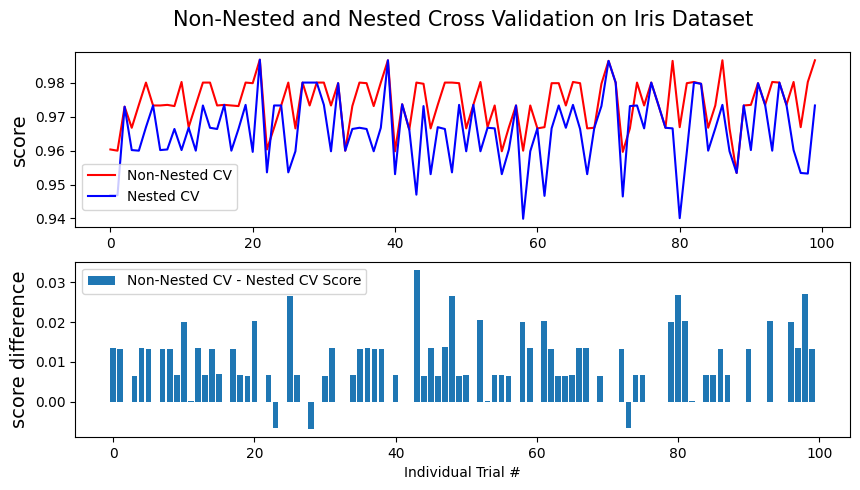

Average difference of 0.008174 with std. dev. of 0.008218.


In [42]:
# Plot scores on each trial for nested and non-nested CV
plt.figure(figsize=(10,5))
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line], ["Non-Nested CV", "Nested CV"], bbox_to_anchor=(0, 0.4, 0.5, 0),)
plt.title("Non-Nested and Nested Cross Validation on Iris Dataset", x=0.5, y=1.1, fontsize="15",)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot], ["Non-Nested CV - Nested CV Score"], bbox_to_anchor=(0, 1, 0.8, 0),)
plt.ylabel("score difference", fontsize="14")

plt.show()

print(f"Average difference of {score_difference.mean():6f} with std. dev. of {score_difference.std():6f}.")


**Considerations**
- The computational expense of *nested* CV is substantially higher than *flat* CV.
- [Nested cross-validation when selecting classifiers is overzealous for most practical applications](https://www.sciencedirect.com/science/article/pii/S0957417421006540)
    - tested with 12 algorithms on 115 real-life binary datasets
    - conclusion: *using the less computationally costly flat CV procedure will generally result in the selection of an algorithm that is, for all practical purposes, of similar quality to that selected via nested CV, provided the learning algorithms have relatively few hyperparameters to be optimised.*

# Further Reading
- [Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#demonstration-of-multi-metric-evaluation-on-cross-val-score-and-gridsearchcv)
- [Searching for optimal parameters with successive halving](https://scikit-learn.org/stable/modules/grid_search.html#searching-for-optimal-parameters-with-successive-halving)